In [83]:
from tensorflow.keras.datasets import boston_housing
# 加载波士顿房价数据集
(train_data, train_targets), (test_data, test_targets) = (
    boston_housing.load_data())

In [84]:
print(train_data.shape,train_targets.shape)

(404, 13) (404,)


In [85]:
#13个数值特征，比如人均犯罪率、住宅的平均房间数、高速公路可达性等。
train_data[0:1]

array([[  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
         91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
         18.72   ]])

In [86]:
#目标值为房价
train_targets[0]

15.2

In [87]:
#数据标准化：输入数据的每个特征（输入数据矩阵的每一列），减去特征平均值，再除以标准差，这样得到的特征平均值为0，标准差为1。
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [88]:
train_data[0:1]

array([[-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
        -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
         1.14850044,  0.44807713,  0.8252202 ]])

In [89]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
    #模型的最后一层只有一个单元且没有激活，它是一个线性层。这是标量回归（标量回归是预测单一连续值的回归）的典型设置。
    model=keras.Sequential([
        layers.Dense(64,activation="relu"),
        layers.Dense(64,activation="relu"),
        layers.Dense(64,activation="relu"),
        layers.Dense(1)
    ])
    #mse损失函数，即均方误差（mean squared error，MSE）预测值与目标值之差的平方。这是回归问题常用的损失函数。
    #训练过程中监控指标：平均绝对误差（mean absolute error，MAE）。它是预测值与目标值之差的绝对值。如果这个问题的MAE等于0.5，就表示预测房价与实际价格平均相差500美元。
    model.compile(optimizer="rmsprop",loss="mse",metrics=["mae"])
    return model

In [97]:
import numpy as np
'''
由于数据点很少，验证集会非常小（比如大约100个样本），因此验证分数可能会有很大波动，验证分数对于验证集的划分方式可能会有很大的方差，这样我们就无法对模型进行可靠的评估。
在这种情况下，最佳做法是使用K折交叉验证
'''
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []
all_scores=[]
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]  #准备验证数据：第k个分区的数据
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(  #准备训练数据：其余所有分区的数据
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()  #构建Keras模型（已编译）
    history=model.fit(partial_train_data, partial_train_targets,  #训练模型（静默模式，verbose=0）
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)  #在验证数据上评估模型
    all_scores.append(val_mae)
    
    mae_history=history.history["mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [102]:
np.mean(all_scores)

2.496902585029602

In [103]:
#计算每轮的K折验证分数平均值
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
# average_mae_history

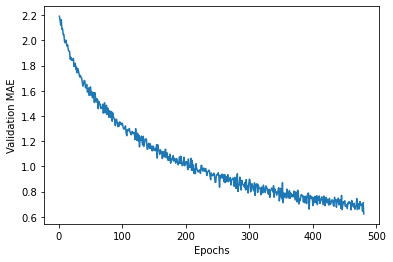

In [104]:
import matplotlib.pyplot as plt
truncated_mae_history = average_mae_history[20:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [105]:
model = build_model()  #一个全新的已编译模型
model.fit(train_data, train_targets,  #在所有训练数据上训练模型
          epochs=500, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 1ms/step - loss: 9.5583 - mae: 2.3130


In [106]:
test_mae_score

2.3130035400390625

In [107]:
#在新数据上进行预测
predictions = model.predict(test_data)
predictions[0]

array([8.289685], dtype=float32)